In [2]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.5 MB/s eta 0:00:00


In [3]:
!git clone https://github.com/yjn870/DnCNN-pytorch.git

Cloning into 'DnCNN-pytorch'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23 (from 1)
Receiving objects: 100% (23/23), 4.18 MiB | 9.47 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset,random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import glob
import os
import numpy as np
from matplotlib import image as mpimg

# Dataset class

In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
import glob
import io
import numpy as np
import PIL.Image as pil_image

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.enable_eager_execution(config=config)


class Dataset(object):
    def __init__(self, images_dir, patch_size,
                 gaussian_noise_level, downsampling_factor, jpeg_quality,
                 use_fast_loader=False):
        self.image_files = sorted(glob.glob(images_dir + '/*'))
        self.patch_size = patch_size
        self.gaussian_noise_level = gaussian_noise_level
        self.downsampling_factor = downsampling_factor
        self.jpeg_quality = jpeg_quality
        self.use_fast_loader = use_fast_loader

    def __getitem__(self, idx):
        if self.use_fast_loader:
            clean_image = tf.read_file(self.image_files[idx])
            clean_image = tf.image.decode_jpeg(clean_image, channels=3)
            clean_image = pil_image.fromarray(clean_image.numpy())
        else:
            clean_image = pil_image.open(self.image_files[idx]).convert('RGB')

        # randomly crop patch from training set
        crop_x = random.randint(0, clean_image.width - self.patch_size)
        crop_y = random.randint(0, clean_image.height - self.patch_size)
        clean_image = clean_image.crop((crop_x, crop_y, crop_x + self.patch_size, crop_y + self.patch_size))

        noisy_image = clean_image.copy()
        gaussian_noise = np.zeros((clean_image.height, clean_image.width, 3), dtype=np.float32)

        # additive gaussian noise
        if self.gaussian_noise_level is not None:
            if len(self.gaussian_noise_level) == 1:
                sigma = self.gaussian_noise_level[0]
            else:
                sigma = random.randint(self.gaussian_noise_level[0], self.gaussian_noise_level[1])
            gaussian_noise += np.random.normal(0.0, sigma, (clean_image.height, clean_image.width, 3)).astype(np.float32)

        # downsampling
        if self.downsampling_factor is not None:
            if len(self.downsampling_factor) == 1:
                downsampling_factor = self.downsampling_factor[0]
            else:
                downsampling_factor = random.randint(self.downsampling_factor[0], self.downsampling_factor[1])

            noisy_image = noisy_image.resize((
                self.patch_size // downsampling_factor,
                self.patch_size // downsampling_factor),
                resample=pil_image.BICUBIC)
            noisy_image = noisy_image.resize((self.patch_size, self.patch_size), resample=pil_image.BICUBIC)

        # additive jpeg noise
        if self.jpeg_quality is not None:
            if len(self.jpeg_quality) == 1:
                quality = self.jpeg_quality[0]
            else:
                quality = random.randint(self.jpeg_quality[0], self.jpeg_quality[1])
            buffer = io.BytesIO()
            noisy_image.save(buffer, format='jpeg', quality=quality)
            noisy_image = pil_image.open(buffer)

        clean_image = np.array(clean_image).astype(np.float32)
        noisy_image = np.array(noisy_image).astype(np.float32)
        noisy_image += gaussian_noise

        input = np.transpose(noisy_image, axes=[2, 0, 1])
        label = np.transpose(clean_image, axes=[2, 0, 1])

        # normalization
        input /= 255.0
        label /= 255.0

        return input, label

    def __len__(self):
        return len(self.image_files)


# DNCNN-B

Epoch 1/3:   0%|          | 0/60000 [00:00<?, ?it/s]/tmp/ipython-input-1369971841.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).to(device)
/tmp/ipython-input-1369971841.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)
Epoch 3/3: 100%|██████████| 60000/60000 [01:29<00:00, 668.23it/s, loss=0.073376]


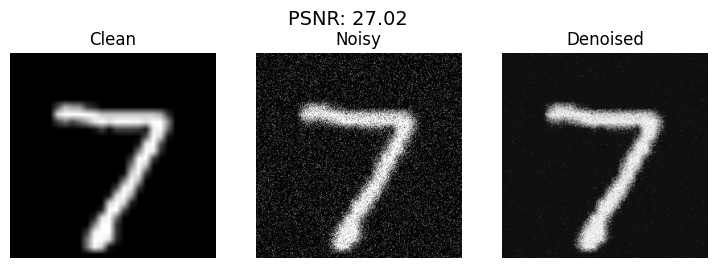

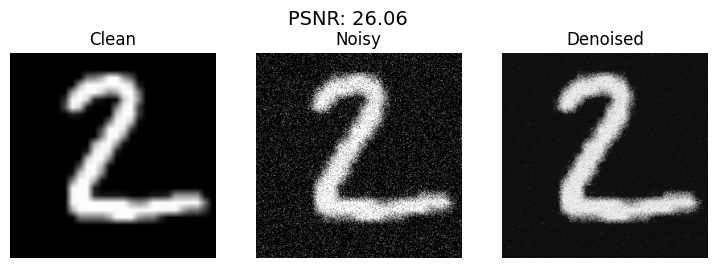

In [17]:
# ----------------------------
# Imports
# ----------------------------
import sys
sys.path.append("./DnCNN_pytorch")


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from pathlib import Path
import random
import numpy as np
from PIL import Image

from DnCNN_pytorch.model import DnCNN


# ----------------------------
# Set Parameters
# ----------------------------
images_dir = Path("./mnist_images")
images_dir.mkdir(exist_ok=True)

outputs_dir = Path("./DnCNN-B-weights")
outputs_dir.mkdir(exist_ok=True)

patch_size = 28
batch_size = 16
num_epochs = 3
lr = 1e-3
sigma_range = (0, 55)
threads = 8
seed = 123
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Save MNIST as images for Dataset
# ----------------------------
train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True)
for idx, (img, _) in enumerate(train_dataset_mnist):
    img = transforms.ToPILImage()(transforms.ToTensor()(img))
    img.save(images_dir / f"{idx}.png")

# ----------------------------
# Dataset and DataLoader
# ----------------------------
dataset = Dataset(
    images_dir=str(images_dir),
    patch_size=patch_size,
    gaussian_noise_level=list(sigma_range),
    downsampling_factor=None,
    jpeg_quality=None,
    use_fast_loader=True
)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=threads,
    pin_memory=True,
    drop_last=True
)

# ----------------------------
# DnCNN-B Model
# ----------------------------
model = DnCNN(num_layers=20)  # 20-layer blind Gaussian
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss(reduction='sum')

# ----------------------------
# Blind Gaussian Noise Helper
# ----------------------------
def add_noise(x, sigma_range=(0, 55)):
    sigma = random.uniform(*sigma_range) / 255.0
    noisy = x + torch.randn_like(x) * sigma
    return torch.clamp(noisy, 0, 1)

# ----------------------------
# Training Loop
# ----------------------------
from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    with tqdm(total=len(dataset) - len(dataset) % batch_size) as _tqdm:
        _tqdm.set_description(f"Epoch {epoch+1}/{num_epochs}")
        for inputs, labels in dataloader:
            inputs = torch.tensor(inputs).to(device)
            labels = torch.tensor(labels).to(device)

            preds = model(inputs)
            loss = criterion(preds, labels) / (2 * len(inputs))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _tqdm.set_postfix(loss=f"{epoch_loss/(_tqdm.n + 1):.6f}")
            _tqdm.update(len(inputs))

    # Save checkpoint
    torch.save(model.state_dict(), outputs_dir / f"DnCNN-B_epoch_{epoch}.pth")

# ----------------------------
# Visualize Test Images
# ----------------------------
test_dataset_mnist = datasets.MNIST(root='./data', train=False, download=True,
                                    transform=transforms.Compose([transforms.Resize((256,256)),
                                                                  transforms.ToTensor()]))

test_loader = DataLoader(test_dataset_mnist, batch_size=2, shuffle=False)

model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        images_3c = images.repeat(1, 3, 1, 1)  # replicate grayscale to 3 channels
        noisy_images = add_noise(images_3c, sigma_range=sigma_range).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = psnr(clean.numpy(), denoised.numpy(), data_range=1.0)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break
